In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 
import math 
import scipy.stats as stats
import statsmodels.api as sm


# set of helper functions that perform projection of vectors
def projection_matrix(x):
    return (x @ (np.linalg.inv(x.T@x)) @ x.T)

def project(v,x):
    return projection_matrix(x) @ v

def projection_components(v,x):
    return (np.linalg.inv(x.T @ x)) @ x.T @ v


"""
Linear regression model using least sqares from scatch. Tried implementing the algorithm straight from the text book as an 
exercise fot further learning.
"""

# wrapper class of model
class Linear_Regression():
        
    # data shoulf be a 2d np array where rows are observations and columns are the features.
    # Y should be a column vector representing the observe results
    def __init__(self):
        
        # number of observations
        self.N = None
        # degree of polymonial
        self.degree = None

        # array of paramaters
        self.param = None
        
        # number of parameters is the number of features + y intercept
        self.nf = None

        # Holds the regresion results and statistics for analysis
        self.summary = {}

    
    
    # reshape data into the correct shape if data is only a 1d array
    def fix_data(self,X,Y):
        if len(X.shape) == 1:
            X = X.reshape((X.shape[0],1))
            
        Y = Y.reshape((Y.shape[0],1))
        
        return X,Y
        
    # returns a design matrix
    def design_matrix(self,X):
        
        V = np.vander(X[:,0],self.degree+1,increasing=True)
        for i in range(1,self.nf):
            v = np.vander(X[:,i],self.degree+1,increasing=True)
            V = np.hstack((V,v[:,1:]))
        return V

        
    # performs OLS and return the parameters that best fit the line.
    def fit(self,X,Y,degree = 1):
        
        X,Y = self.fix_data(X,Y)
        
        self.N = X.shape[0]
        self.degree = degree
        self.nf = X.shape[1]
        
        # gets the design matrix  
        A = self.design_matrix(X)
    
        self.param = (np.linalg.inv(A.T @ A) @ A.T @ Y)

        self.regresion_stats(X,Y)
        
        return self.param      

        
    # performs a preditction given an observation.
    def predict(self,X):

        if(len(X.shape) == 1):
            X = X.reshape(1,X.shape[0])
            
        X = self.design_matrix(X)    
        return X @ self.param


    


    def regresion_stats(self,X,Y):
        X,Y = self.fix_data(X,Y)
        self.summary['MAE'] = self.MAE(X,Y)
        self.summary['MSE'] = self.MSE(X,Y)
        self.summary['RSS'] = self.RSS(X,Y)
        self.summary['R2']  = self.R2(X,Y)
        self.summary['RSE'] = self.RSE(X,Y)
        self.summary['F_stat'] = self.F_stat(X,Y)
        self.summary['F_p_val'] = self.F_p_val(self.summary['F_stat'])
        self.summary['Var_param'] = self.var_param(X,Y)
        
        
        
    def MSE(self,test_x,test_y):
        tx,ty = self.fix_data(test_x,test_y)
        n = tx.shape[0]
        return self.RSS(tx,ty)/(n - self.nf-1)

    def MAE(self,X,Y):
        tx,ty = self.fix_data(X,Y)
        n = tx.shape[0]
        return np.sum(abs(ty - self.predict(tx)))
        
        
    def RSS(self,X,Y):
        tx,ty = self.fix_data(X,Y)
        return np.sum((ty - self.predict(tx))**2)

    def R2(self,X,Y):
        tx,ty = self.fix_data(X,Y) 
        mean = np.mean(Y)

        tss = np.sum((Y - mean)**2)
        rss = self.RSS(tx,ty)

        return (tss-rss)/tss

    def RSE(self,X,Y):
        n = X.shape[0]
        rss = self.RSS(X,Y) * ((n-self.nf-1)**-1)
        return math.sqrt(rss)

    def F_stat(self,X,Y):
        mean = np.mean(Y)
        tss = np.sum((Y - mean)**2)
        rss = self.RSS(X,Y)
        n = X.shape[0]

        N = (tss - rss)/self.nf
        D = rss/(n-self.nf-1)
        return N/D

    def sigma_sqare(self,X,Y):
        if self.nf == 1:
            return self.RSE(X,Y)**-2
        n = X.shape[0]
        return self.RSS(X,Y)/(n - self.nf - 1)


    def F_p_val(self,F):
     p_value = 1 - stats.f.cdf(F, 1, self.nf+1)
     return p_value

    def var_param(self,X,Y):
        A = self.design_matrix(X)
        V  = np.linalg.inv(A.T @ A)
        s2 = self.MSE(X,Y)

        result = {}

        for i in range(V.shape[0]):
            se = math.sqrt(s2*V[i,i])
            result[f"B{i}"] = {'value' : self.param[i][0],'SE' : se, 't_stats':self.param[i][0]/se, 'p_val':self.t_p_val(self.param[i][0]/se)}
            
        return result

    def t_p_val(self,t_statistic):
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df=self.nf+1))
        return p_value


    def info(self):
        print(f"---------------------------------------------")
        for i in model.summary.keys():
            if i != 'Var_param':
                print(f"{i} : {self.summary[i]}")
            else:
                print(f"\ncoeficients |  values  |  SE  |  t_stat  | p value |")
                for b in self.summary[i].keys():
                    s = self.summary[i][b]
                    print(f"{b} | {s['value']:.3f} | {s['SE']:.3f} | {s['t_stats']:.3f} | {s['p_val']:.3f}")
        
    

    

---------------------------------------------
MAE : 48.89169032968928
MSE : 0.2520190223179823
RSS : 24.445845164844282
R2 : 0.9999723008881646
RSE : 0.502014962245133
F_stat : 1750910.169290657
F_p_val : 9.518621446602538e-10

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | 9.285 | 0.153 | 60.597 | 0.000
B1 | 2.004 | 0.003 | 754.530 | 0.000
B2 | 3.001 | 0.002 | 1744.738 | 0.000
----------stat model----------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.751e+06
Date:                Wed, 14 May 2025   Prob (F-statistic):          9.11e-222
Time:                        12:08:24   Log-Likelihood:                -71.458
No. Observations:                 100   AIC:                             148.9
Df Residuals:           

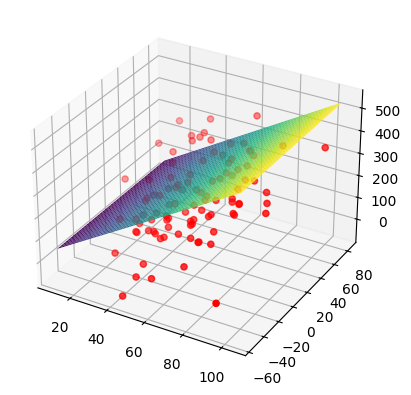

In [2]:
f = lambda x,y: 10 + 2*x + 3*y

X = np.random.normal(50,20,100)
Y = np.random.normal(20,30,100)

data = np.array([X,Y]).T
F = np.array([f(X[i],Y[i]) + np.random.randint(-1,1) for i in range(X.shape[0])])


model = Linear_Regression()
model.fit(data,F)
model.info()

print(f"----------stat model----------")
mod = sm.OLS(F,model.design_matrix(data))
res = mod.fit()
print(res.summary())


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X,Y,F,color = 'red')

MX,MY = np.meshgrid(np.linspace(np.min(X),np.max(X)),np.linspace(np.min(Y),np.max(Y)))
Z = model.param[0] + model.param[1]*MX + model.param[2]*MX
ax.plot_surface(MX, MY, Z,cmap='viridis')







---------------------------------------------
MAE : 5018.407151468861
MSE : 33.788520511343584
RSS : 33687.154949809556
R2 : 0.9999999942602356
RSE : 5.812789391621168
F_stat : 86850254776.91774
F_p_val : 1.1102230246251565e-16

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | 4.222 | 0.262 | 16.099 | 0.001
B1 | 3.001 | 0.002 | 1592.858 | 0.000
B2 | 5.000 | 0.000 | 356619.565 | 0.000
B3 | 1.000 | 0.002 | 530.695 | 0.000
B4 | 3.000 | 0.000 | 231250.306 | 0.000
----------stat model----------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.334e+10
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        12:08:24   Log-Likelihood:                -3177.5
No. Observations:     

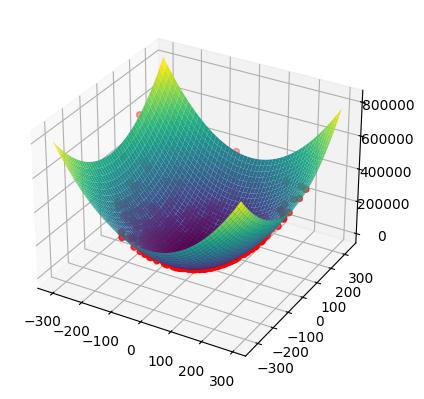

In [3]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d

f = lambda x,y: 5 + 3*x + 5*x**2 + y + 3*y**2  

X = np.random.normal(0,100,1000)
Y = np.random.normal(0,100,1000)
F = np.array([f(x,y) + np.random.randint(-10,10) for x,y in zip(X,Y)])


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X,Y,F,color = 'red')



model = Linear_Regression()
model.fit(np.array([X,Y]).T,F,2)
model.info()


print(f"----------stat model----------")
mod = sm.OLS(F,model.design_matrix(np.array([X,Y]).T))
res = mod.fit()
print(res.summary())


MX,MY = np.meshgrid(np.linspace(np.min(X),np.max(X)),np.linspace(np.min(Y),np.max(Y)))
Z = model.param[0] + model.param[1]*MX + model.param[2]*MX**2 + model.param[3]*MY + model.param[4]*MY**2
ax.plot_surface(MX, MY, Z,cmap='viridis')


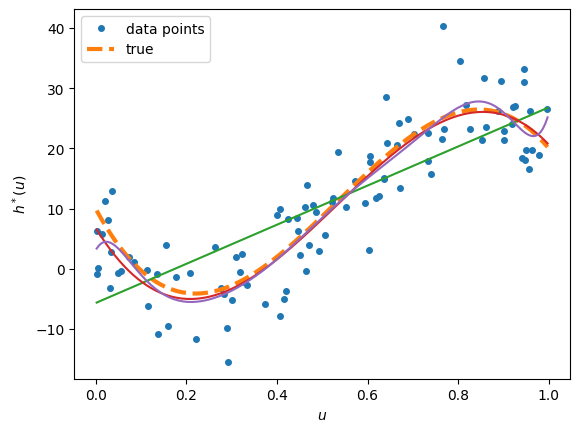

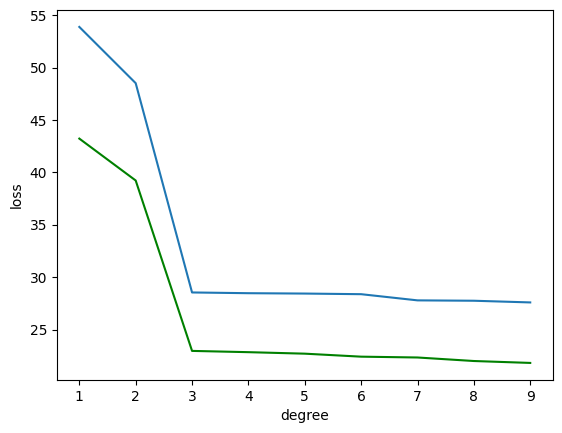

In [4]:
from numpy.random import rand , randn

def generate_data (beta , sig , n):
    u = np.random.rand(n, 1)
    y = (u ** np.arange (0, 4)) @ beta + sig * np.random.randn(n, 1)
    return u, y


np.random.seed (12)
beta = np.array ([[10 , -140, 400, -250]]).T
n = 100
sig = 5
u, y = generate_data (beta , sig , n)
xx = np.arange(np.min(u), np.max(u)+5e-3, 5e-3)
yy = np.polyval(np.flip(beta),xx)
plt.plot(u, y, '.', markersize =8)
plt.plot(xx , yy , '--',linewidth =3)
plt.xlabel(r'$u$')
plt.ylabel(r'$h^*(u)$')
plt.legend(['data points','true'])





model = Linear_Regression()

P = [i for i in range(1,10)]
loss, param, Gloss = {}, {}, {}

tu, ty = generate_data (beta , sig , 100)

for p in P:
     param[p] = model.fit(u,y,p)
     loss[p] = (np.linalg.norm(y - np.vander(u[:,0],p+1,True) @ param[p])**2)/n
     Gloss[p] = (np.linalg.norm(ty - np.vander(tu[:,0],p+1,True) @ param[p])**2)/n

for p in [1,3,9]:
    plt.plot(xx,np.vander(xx,p+1,True)@param[p])
    
    
plt.show() 

plt.plot(P,loss.values())
plt.plot(P,Gloss.values(),c = 'g')
plt.xlabel("degree")
plt.ylabel("loss")

plt.show()



In [13]:
path = 'Data/HeightWeight.csv'
raw_data = pd.read_csv(path)

raw_data.columns = ['ID', 'Height', 'Weight']
raw_data = raw_data.sort_values('Height')

H = raw_data['Height'].to_numpy()
W = raw_data['Weight'].to_numpy()

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(H, W)

weight_predictor = Linear_Regression()
weight_predictor.fit(X_train,Y_train)
weight_predictor.info()

print("------Test data-------")
weight_predictor.regresion_stats(X_test,Y_test)
weight_predictor.info()


print(f"----------stat model----------")
dm = weight_predictor.design_matrix(np.array([X_train]).T)
mod = sm.OLS(Y_train,dm)
res = mod.fit()
print(res.summary())




---------------------------------------------
MAE : 150907.21575697663
MSE : 101.47986050957529
RSS : 1902544.4248335175
R2 : 0.2493276465893009
RSE : 10.073721284092354
F_stat : 6226.944014946042
F_p_val : 0.00016055374408840972

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | -81.321 | 2.642 | -30.783 | 0.001
B1 | 3.065 | 0.039 | 78.911 | 0.000
------Test data-------
---------------------------------------------
MAE : 50028.002824188305
MSE : 101.9856119743244
RSS : 637206.1036155788
R2 : 0.2631682613185875
RSE : 10.098792599827188
F_stat : 2231.5478696140663
F_p_val : 0.0004478184564487009

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | -81.321 | 4.518 | -17.999 | 0.003
B1 | 3.065 | 0.066 | 46.173 | 0.000
----------stat model----------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                 

In [16]:

path = 'Data/Fish[1].csv'
fish = pd.read_csv(path)
fish = fish.sort_values('Species')


unique_fish = fish['Species'].unique()
fish_dict = {}
i = 0
for k in unique_fish:
    fish_dict[k] = i
    i += 1

S = np.array([fish_dict[f] for f in fish['Species']]).reshape(159,1)
Y = fish['Weight'].to_numpy()
X = np.hstack((S,fish[['Length1','Length2','Length3','Height','Width']].to_numpy()))




X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y)


fish_model = Linear_Regression()
fish_model.fit(X_train,Y_train)
fish_model.info()
print("------Test data-------")
fish_model.regresion_stats(X_test,Y_test)
fish_model.info()






print(f"----------stat model----------")
dm = fish_model.design_matrix(X_train)
mod = sm.OLS(Y_train,dm)
res = mod.fit()
print(res.summary())




---------------------------------------------
MAE : 9865.374784128278
MSE : 14144.233808949659
RSS : 1584154.1866023617
R2 : 0.8947847601876248
RSE : 118.92953295523218
F_stat : 158.74742942771985
F_p_val : 4.581141342607786e-06

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | -659.032 | 54.176 | -12.165 | 0.000
B1 | 34.395 | 10.758 | 3.197 | 0.015
B2 | -5.439 | 47.365 | -0.115 | 0.912
B3 | 94.266 | 50.675 | 1.860 | 0.105
B4 | -63.970 | 21.097 | -3.032 | 0.019
B5 | 57.198 | 12.478 | 4.584 | 0.003
B6 | -18.090 | 26.745 | -0.676 | 0.521
------Test data-------
---------------------------------------------
MAE : 3631.459157414567
MSE : 18325.47708142688
RSS : 604740.7436870871
R2 : 0.8825552874001463
RSE : 135.3716258357965
F_stat : 41.33054586492172
F_p_val : 0.00035734297221468037

coeficients |  values  |  SE  |  t_stat  | p value |
B0 | -659.032 | 105.447 | -6.250 | 0.000
B1 | 34.395 | 21.540 | 1.597 | 0.154
B2 | -5.439 | 90.874 | -0.060 | 0.954
B3 | 94.266 | 97.769 | 0.964 |